In [1]:
import os
# Prevent CUDA from using GPU as it does not work well on my pc
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Set Constants of the model
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

In [2]:
# Helper functions
import numpy as np

# Breaks down a list of integer values into a one-hot like format
def one_hot_training(np_array):
    transformed_list = []
    for arr in np_array:
        new_arr = np.zeros(10)
        new_arr[int(arr)] = 1
        transformed_list.append(new_arr)
    return np.array(transformed_list)

# This translates the highest value from the one-hot encoding into the correct sign name
def one_hot_translator(np_array):
    labels_names = ['Stop','Yield','Red Light','Green Light','Roundabout','Right Turn Only',
                'Do Not Enter','Crosswalk','Handicap Parking','No Parking']
    return labels_names[np.argmax(np_array)]

# This translates an entire array of one-hot encoded sign predictions
def translate_all(np_array):
    translated_values = []
    for i in np_array:
        translated_values.append(one_hot_translator(i))
    return np.array(translated_values)

In [3]:
# First import the data
data_train = np.load('data_train.npy').transpose()
labels_train = np.load('labels_train.npy')
data_train = np.array([i.reshape(300,300,3) for i in data_train])

In [4]:
# Process the data so that it is in the expected form for the InceptionV3 model
import tensorflow as tf
processed = tf.keras.applications.inception_v3.preprocess_input(data_train, data_format=None)

# Break down data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, t_train, t_test = train_test_split(processed, one_hot_training(labels_train), test_size=0.20, random_state=1)

In [5]:
# Import the InceptionV3 Model

from tensorflow.keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(input_shape=(300,300,3),
                       include_top=False,
                       weights='imagenet')

# Set layers to false to prevent overwriting the existing model
for layer in inception.layers:
    layer.trainable = False

# Create output layers that will be trained
from tensorflow.keras.optimizers import RMSprop
x = tf.keras.layers.Flatten()(inception.output)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

# Finalize and compile the model
model = tf.keras.Model(inception.input, outputs = x)
model.compile(optimizer = RMSprop(learning_rate=0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['acc'])

In [6]:
# Fit the model to the dataset

callbacks = tf.keras.callbacks.Callback()
history = model.fit(x_train, t_train, epochs=3, batch_size=64)
model.save("first_run.h5")

Epoch 1/3
78/78 [==============================] - 225s 3s/step - loss: 3.2542 - acc: 0.7312
Epoch 2/3
78/78 [==============================] - 209s 3s/step - loss: 0.4857 - acc: 0.9017
Epoch 3/3
78/78 [==============================] - 210s 3s/step - loss: 0.3052 - acc: 0.9405


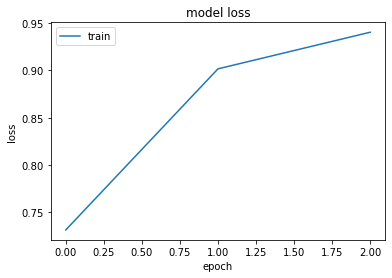

In [7]:
# Plot the progression of the accuracy through the epochs

import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 1s/step
Yield


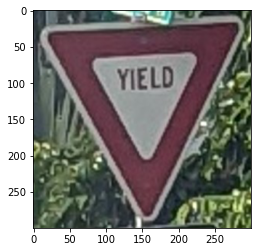

In [8]:
# Demo to randomly pick a sign and demonstrate that it is predicted correctly

from random import randint
test_image = randint(0,len(data_train))
test = np.expand_dims(data_train[test_image], axis=0)
test = tf.keras.applications.inception_v3.preprocess_input(
    test, data_format=None
)
print(one_hot_translator(model.predict(test)))
plt.imshow(data_train[test_image])

In [9]:
# Calculate the predictions for the test values
predictions = model.predict(x_test)

39/39 [==============================] - 39s 1s/step


In [11]:
evaluation = model.evaluate(x_test, t_test)
print("Test run accuracy is {}".format(evaluation[-1]))

39/39 [==============================] - 39s 987ms/step - loss: 1.3513 - acc: 0.7821
[1.351330041885376, 0.7820823192596436]


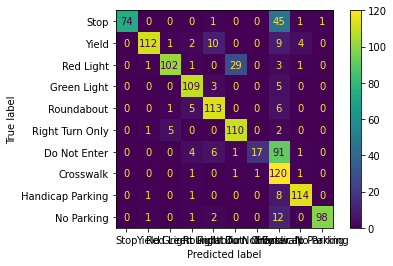

In [10]:
# Create a Confusion Matrix to show the weakness in the model

predicted_values = translate_all(predictions)
real_values = translate_all(t_test)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cfm = confusion_matrix(real_values, predicted_values)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=['Stop','Yield','Red Light','Green Light','Roundabout','Right Turn Only','Do Not Enter','Crosswalk','Handicap Parking','No Parking'])
disp.plot()
plt.show()